In [3]:
import pandas as pd
import numpy as np
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from numba import jit, njit, prange
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit, prange,jit

In [4]:
from pmdarima.arima import AutoARIMA, ARIMA
from pmdarima.pipeline import Pipeline as Pipe_ARI

In [3]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from statsmodels.tsa.arima.model import ARIMA

# class ARIMATransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, p=1, d=1, q=1):
#         self.p = p
#         self.d = d
#         self.q = q

#     def fit(self, X, y=None):
#         # Assuming X is a time series (1D array or pandas Series)
#         self.arima_model = ARIMA(X, order=(self.p, self.d, self.q))
#         self.arima_fit = self.arima_model.fit()

#         return self

#     def transform(self, X):
#         # Assuming X is a time series (1D array or pandas Series)
#         # Transform can be used to make predictions
#         predictions = self.arima_fit.predict(start=len(X), end=len(X) + len(X) - 1, typ='levels')

#         return np.array(predictions)


In [5]:
#train-test-split
from sklearn.model_selection import train_test_split

#preprocessors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

#pipeline
from sklearn.pipeline import Pipeline

#models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import xgboost 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

#CV
from sklearn.model_selection import cross_val_score,RandomizedSearchCV

#errors
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_squared_log_error

In [6]:
df_train=pd.read_csv("train.csv")
df_train.date=pd.to_datetime(df_train.date)
df_train=df_train.sort_values(by=["id","date"]).reset_index(drop=True)
train_ini_date=df_train.date.iloc[0]
train_fin_date=df_train.date.iloc[-1]

df_test=pd.read_csv("test.csv")
df_test.date=pd.to_datetime(df_test.date)
df_test=df_test.sort_values(by=["id","date"]).reset_index(drop=True)
test_ini_date=df_test.date.iloc[0]
test_fin_date=df_test.date.iloc[-1]

holidays=pd.read_csv("holidays_events.csv")
holidays.date=pd.to_datetime(holidays.date)
holidays=holidays.sort_values(by="date").reset_index(drop=True)

oil=pd.read_csv("oil.csv")
oil.date=pd.to_datetime(oil.date)
oil=oil.sort_values(by="date").reset_index(drop=True)

stores=pd.read_csv("stores.csv")

transactions=pd.read_csv("transactions.csv")
transactions.date=pd.to_datetime(transactions.date)
transactions=transactions.sort_values(by="date").reset_index(drop=True)

In [7]:
df_train.sales=np.log1p(df_train.sales)

# Section 1: EDA & Engineering

In [7]:
# df_train["oil_price"]=np.nan
# for date in df_train.date.unique():
#     if (date in oil.date.values)==True:
#         train_mask=(df_train.date==date)
#         oil_mask=(oil.date==date)
#         df_train["oil_price"][train_mask]=np.repeat(oil["dcoilwtico"][oil_mask].values,train_mask.sum())
# df_train

In [8]:
#restrict holidays to train+test dates
mask=(holidays.date>=train_ini_date) & (holidays.date<=test_fin_date)
holidays=holidays[mask].reset_index(drop=True)
holidays

,date,type,locale,locale_name,description,transferred
0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
2,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
3,2013-02-11,Holiday,National,Ecuador,Carnaval,False
4,2013-02-12,Holiday,National,Ecuador,Carnaval,False
...,...,...,...,...,...,...
282,2017-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
283,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
284,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
285,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False


## Some plots:

In [9]:
def hist_plotter(data,nplots_on_row,cols):
    ncols=len(cols)

    rows_numb=ncols/nplots_on_row # how many rows will we need to display nplots_on_row per each line?

    if int(rows_numb)<rows_numb: #increase by 1 since we need 1 extra row for some graphs
        rows_numb=int(rows_numb)+1 #<- so like if we need 3.5 rows, do 4 since we can't do 3.
    rows_numb=int(rows_numb)
    fig,axes=plt.subplots(rows_numb,nplots_on_row,figsize=(20,10)) #define structure
    counter=0 #what col are we at of cols?

    flag=0
    try: #do we have more than 1 row for axes?
        axes.shape[1]
    except:
        flag=1

    for row in range(rows_numb): #loop through rows of subplots
        for col in range(nplots_on_row): #and through columns
            if flag==0:
                sns.histplot(x=data[cols[counter]],ax=axes[row,col],bins=data[cols[counter]].unique().shape[0],kde=True)
                axes[row,col].set_title(cols[counter])
                axes[row,col].set_xlabel("")
                for tick in axes[row,col].get_xticklabels():
                    tick.set_rotation(45)
            else:
                sns.histplot(x=data[cols[counter]],ax=axes[row],bins=data[cols[counter]].unique().shape[0],kde=True)
                axes[row].set_title(cols[counter])
                axes[row].set_xlabel("")
                for tick in axes[row].get_xticklabels():
                    tick.set_rotation(45)

            counter+=1
    fig.suptitle("Histograms of all the variables",fontsize=24)
    plt.show()

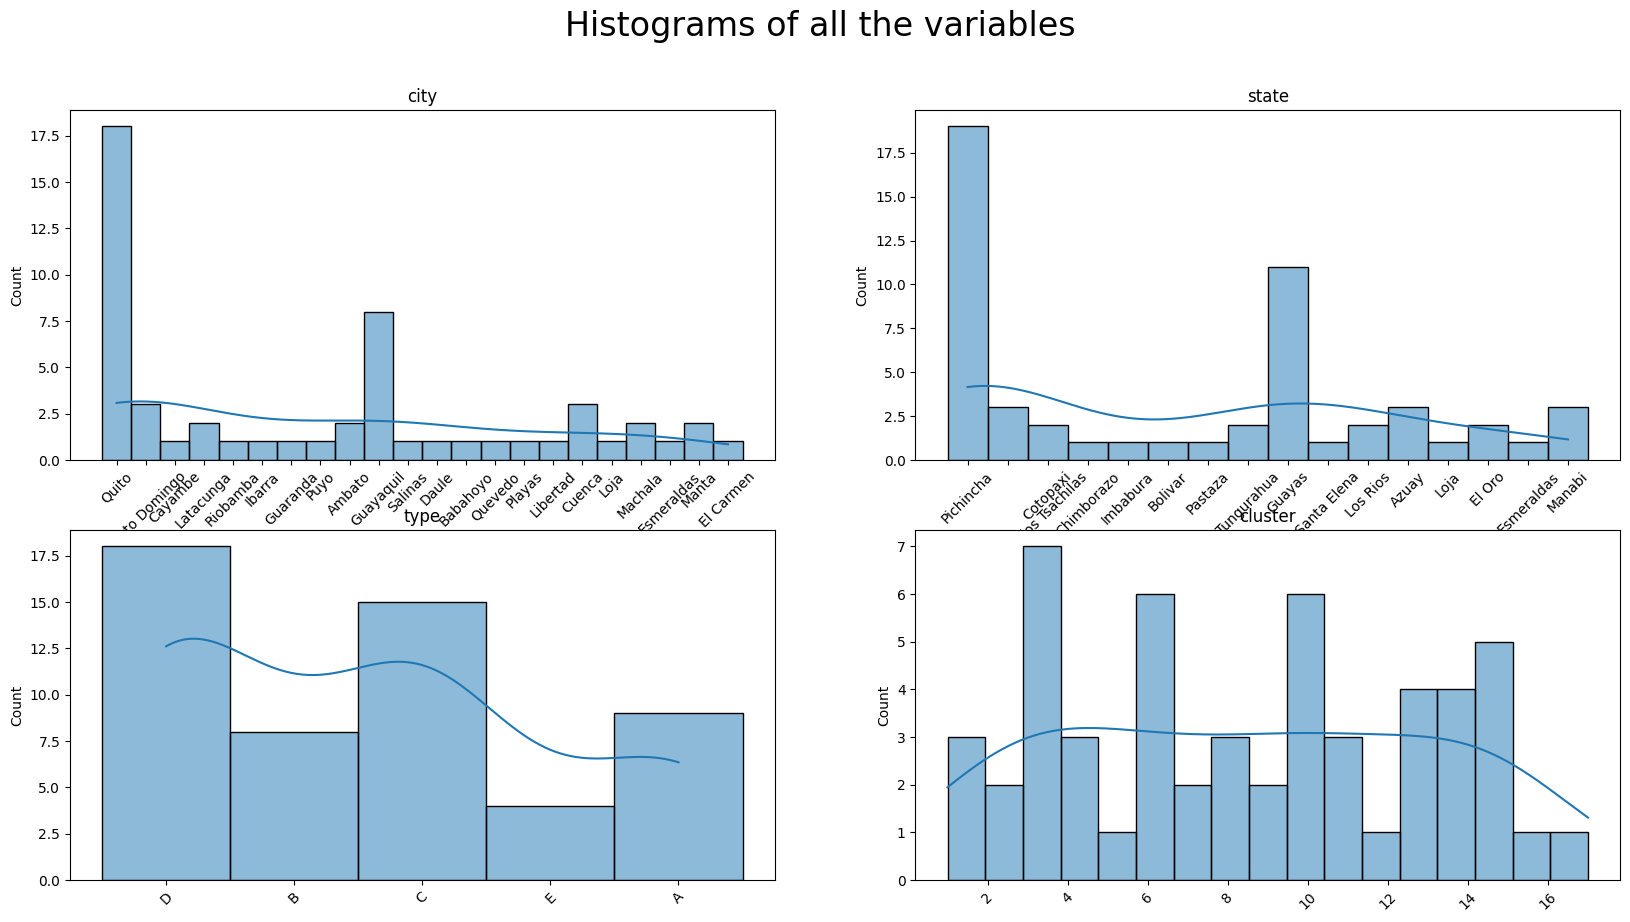

In [10]:
hist_plotter(stores,2,stores.columns.values[1:])

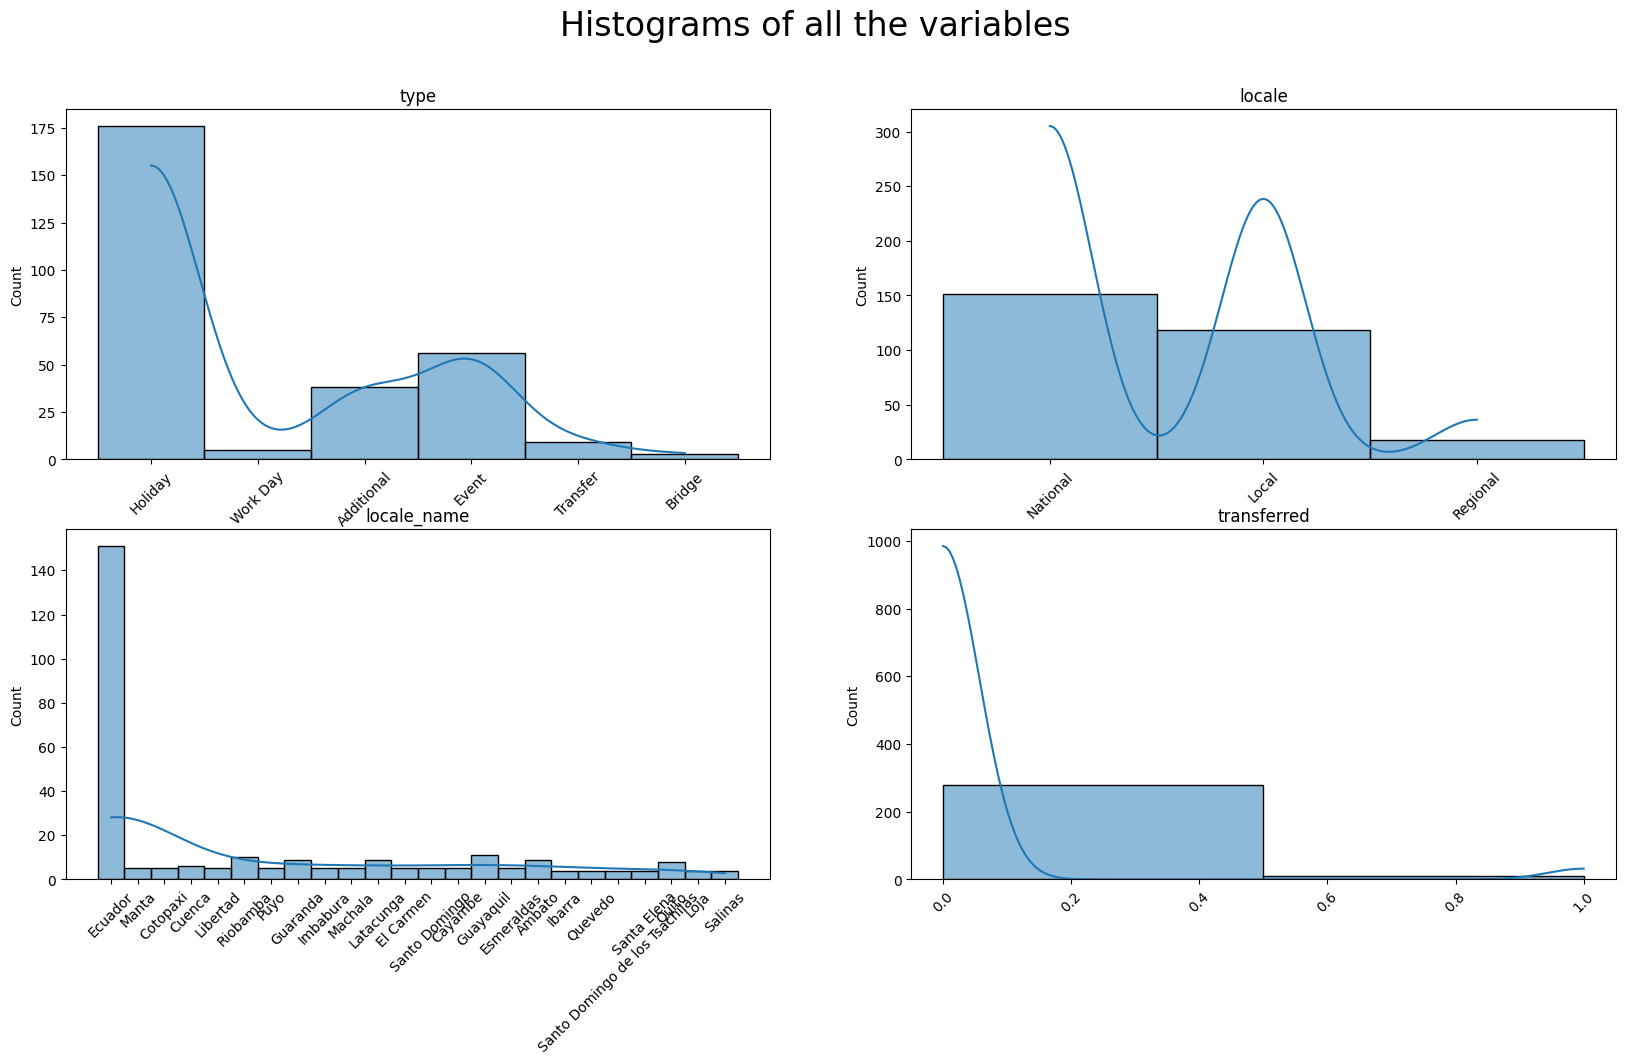

In [11]:
hist_plotter(holidays,2,holidays.columns.values[[1,2,3,5]])

# Models

In [9]:
def combiner(data,holidays,store):
    #Append HOLIDAYS data
    holidays.transferred=holidays.transferred.astype(int)
    data2=pd.merge(data,holidays,on=["date"],how="left")
    mask=(pd.isna(data2.transferred))
    data2["transferred"][mask]=0 #if a holiday is missing, that's because it's not present
    data2.transferred=data2.transferred.astype(int)
    data2=data2.rename(columns={"type":"event_type"})
    
    #Append STORE data
    data3=pd.merge(data2,store,on=["store_nbr"])
    data3=data3.rename(columns={"type":"store_type"})
    return data3

def weeker(data):
    #create a WEEK column
    data["week"]=data.date.dt.isocalendar().week
    return data

def dummy_making(data,columns):
    data2=data.copy()
    for col in columns:
        encoder=OneHotEncoder(sparse_output=False,drop="first",dtype=int) #set output to non sparse, int and drop first dummy
        encoder.set_output(transform='pandas') #want a dataframe as output
        df=encoder.fit_transform(data[[col]]) #create the dummies
        data2=data2.drop(columns=col) #drop the original column
        data2=pd.concat([data2,df],axis=1) #put the dummies in
    return data2

def active_event(data):
    data["active_event"]=0
    for location in data.locale_name.unique():
        if location=="Ecuador":
            mask=(data.locale_name==location) #on the rows where you have the National event
            data["active_event"][mask]=1 #the store is for sure impacted by it
        else: #if the location is LOCAL
            mask=(data.state==location) #only on the rows where store_city==location
            data["active_event"][mask]=1 #the store is  impacted by it
    data=data.drop(columns=["locale_name","state"])
    return data

def dropper(data,columns):
    data2=data.copy()
    for col in columns:        
        data2=data2.drop(columns=col) #drop the original column
    return data2

In [133]:
def data_cleaner(train_set,holidays,stores,categorical_cols,drop_cols,validation_set=None,test_set=None):

    if test_set is None:
        if validation_set is None:
            ###Section 1: Data cleaning and merging
            print("Prepping the data...")
            data=combiner(train_set,holidays,stores) #merge df_train with holidays and store, also convert `transferred` type to int.

            First_Stage=Pipeline([
                ("weeker",FunctionTransformer(weeker)),    
                ("dummying",FunctionTransformer(dummy_making,kw_args={"columns":categorical_cols})),
                ("active_event",FunctionTransformer(active_event)),
                ("dropper",FunctionTransformer(dropper,kw_args={"columns":drop_cols}))
            ])



            new_df=First_Stage.fit_transform(data)
            print("Data prepped. Passing to the model section.\n")

            #now that the df is here, split X from Y
            y_train=new_df.sales
            X_train=new_df.iloc[:,1:]

            # y_train=new_df.sales.values
            # X_train=new_df.iloc[:,1:].values
            # X_train=X_train.astype(np.float32)
            # y_train=y_train.astype(np.float32)
            return X_train,y_train
        else: #validation is here, do a mix of test and train per how you handle the data
            print("Prepping the data...")
            data_train=combiner(train_set,holidays,stores) #merge df_train with holidays and store, also convert `transferred` type to int.

            data_validation=combiner(validation_set,holidays,stores)

            First_Stage=Pipeline([
                ("weeker",FunctionTransformer(weeker)),    
                ("dummying",FunctionTransformer(dummy_making,kw_args={"columns":categorical_cols})),
                ("active_event",FunctionTransformer(active_event)),
                ("dropper",FunctionTransformer(dropper,kw_args={"columns":drop_cols}))
            ])


            new_df_train=First_Stage.fit_transform(data_train)
            new_df_test=First_Stage.fit_transform(data_validation)

            for col in new_df_train.columns.values:
                if col not in new_df_test.columns.values:
                        new_df_test[col]=0
            
            new_df_test=new_df_test[new_df_train.columns] #spit out test data ordered as train data (sales IS present, but filled with 0)
            print("Data prepped. Passing to the model section.\n")
            X_val=new_df_test.iloc[:,1:]
            y_val=new_df_test.sales
            # X_val=new_df_test.iloc[:,1:].values
            # y_val=new_df_test.sales.values
            # X_val=X_val.astype(np.float32)
            # y_val=y_val.astype(np.float32)
            return X_val,y_val             

    else: #test set is present
        ###Section 1: Data cleaning and merging
        print("Prepping the data...")
        data_train=combiner(train_set,holidays,stores) #merge df_train with holidays and store, also convert `transferred` type to int.

        data_test=combiner(test_set,holidays,stores)

        First_Stage=Pipeline([
            ("weeker",FunctionTransformer(weeker)),    
            ("dummying",FunctionTransformer(dummy_making,kw_args={"columns":categorical_cols})),
            ("active_event",FunctionTransformer(active_event)),
            ("dropper",FunctionTransformer(dropper,kw_args={"columns":drop_cols}))
        ])


        new_df_train=First_Stage.fit_transform(data_train)
        new_df_test=First_Stage.fit_transform(data_test)

        for col in new_df_train.columns.values:
            if col not in new_df_test.columns.values:
                    new_df_test[col]=0
        
        new_df_test=new_df_test[new_df_train.columns] #spit out test data ordered as train data (sales IS present, but filled with 0)
        print("Data prepped. Passing to the model section.\n")
        X_train=new_df_test.iloc[:,1:]
        X_train=X_train.astype(np.float32)
        return X_train

In [19]:
def model_fitter(X_train,y_train,algo_type,model_params=None,verbose=10,scoring="neg_mean_absolute_error",n_iter=100,cv=5,X_val=None,y_val=None):

    if algo_type.__name__=="ARIMA":
        model=Pipe_ARI([
            ("reg",algo_type(order=(1,1,1),maxiter=100,out_of_samples_size=y_train.shape[0]/10))
        ])
    elif algo_type.__name__=="RandomForestClassifier":
        model=Pipeline([
            ("reg",algo_type(n_estimators=5))
        ])
    elif algo_type.__name__=="LGBMClassifier":
        model=Pipeline([
            ("reg",algo_type(force_col_wise=True))
        ])
       
    elif algo_type.__name__=="train": #xgboost
        dtrain=xgboost.DMatrix(np.hstack([y_train.reshape(-1, 1),X_train]))
        dval=xgboost.DMatrix(np.hstack([y_val.reshape(-1, 1),X_val]))
        model=Pipeline([
            ("reg",algo_type(subsample=0.8,tree_method="gpu_hist",predictor="gpu_predictor"))
        ])
       
    else:
        model=Pipeline([
            ("reg",algo_type())
        ])

    ###Section 2: Baseline Model Results
    #Run the baseline model
    model.fit(X=X_train,y=y_train)
    pred=model.predict(X_train)
    mae=mean_absolute_error(y_train,pred)
    mse=mean_squared_error(y_train,pred)
    print("BASELINE MODEL IS SCORES:")
    print("MAE:",np.round(mae,3)," MSE:",np.round(mse,3),end="\n")


    ###(Optional) Section 3: Optimized Model Results - user specific
    #Optimize it based on the user's choices:
    if model_params!=None:
        print("Now optimizing model...")
        # opt_model=RandomizedSearchCV(model,model_params,cv=cv,n_iter=n_iter,scoring=scoring,verbose=verbose,n_jobs=-3,pre_dispatch=3)
        opt_model=RandomizedSearchCV(model,model_params,cv=cv,n_iter=n_iter,scoring=scoring,verbose=verbose,n_jobs=-1,pre_dispatch=3)
        opt_model.fit(X=X_train,y=y_train)
        pred=opt_model.predict(X_train)
        mae=mean_absolute_error(y_train,pred)
        mse=mean_squared_error(y_train,pred)
        print("\n\nOPTIMIZED MODEL IS SCORES")
        print("MAE:",np.round(mae,3)," MSE:",np.round(mse,3),end="\n")
        print(opt_model.best_params_)
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++",end="\n")
        return opt_model
    else:
        return model

In [17]:
models=[Lasso,Ridge,LinearRegression,RandomForestClassifier,LGBMClassifier,xgboost.train,ARIMA]

parameters=[

    {
    "reg__alpha":[0.5,1,1.5],
    "reg__selection":["random","cyclic"],
},

{
    "reg__alpha":[0.5,1,1.5],
    "reg__solver":["auto","svd","sparse_cg","lsqr","lbfgs"],
},

{
    "reg__fit_intercept":[True,False]
},

{
    "reg__alpha":[0.5,1,1.5],
    "reg__selection":["random","cyclic"]
},

{
    "reg__alpha":[0.5,1,1.5],
    "reg__selection":["random","cyclic"]
},
{
    "reg__n_estimators":[100,500],
    "reg__max_depth":[20],
    "reg__learning_rate":[0.01,0.04,0.05],
    "reg__alpha":[1e-3,0.01],
    "reg__lambda":[1e-3,0.01]
},
{
    "reg__order":[(1,0,0),(1,1,0),(1,1,1)],
    "reg__information_criterion":["aic","bic"],
    "reg__method":["newton","nm","cg"]
}]

#Lasso=0
#Ridge=1
#OLS=2
#RCF=3
#LGB=4
#XGB=5
#ARIMA=6  ###TO IMPROVE

In [16]:
#Currently, RandomForest requires too much ram that my 32gb can't fit.

#Wondering whether I should go for 96gb

#Currently, LGBM returns: OSError: exception: access violation writing 0x0000000000000000

## Baseline: Family FE

In [17]:
# version="FAM_FE_"
# #columns to dummify
# categorical_cols=["family"]
# #columns to drop
# drop_cols=["id","date","locale","description","city","store_type","cluster","event_type","store_nbr","week"]


# X_train,y_train=data_cleaner(df_train,holidays,stores,categorical_cols,drop_cols)


In [18]:
# device="cpu"
# optimized_models=dict()
# working_models=[0,1,2,5]
# for i in working_models:
#     model_params=parameters[i]
#     algo=models[i]
#     print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++",end="\n")
#     print("MODEL CHOSEN:",algo.__name__,end="\n")
#     globals()[version+str(algo.__name__)]=model_fitter(X_train,y_train,algo,model_params,verbose=10,device=device)
#     optimized_models[version+str(algo.__name__)]=globals()[version+str(algo.__name__)]

## Baseline: Family, Store, Week FE

In [19]:
# version="FAM+STORE+WEEK_FE_"
# #columns to dummify
# categorical_cols=["family","store_nbr","week"]
# #columns to drop
# drop_cols=["id","date","locale","description","city","store_type","cluster","event_type"]


# X_train,y_train=data_cleaner(df_train,holidays,stores,categorical_cols,drop_cols)


In [20]:
# device="cpu"
# optimized_models=dict()
# working_models=[0,1,2,5]
# for i in working_models:
#     model_params=parameters[i]
#     algo=models[i]
#     print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++",end="\n")
#     print("MODEL CHOSEN:",algo.__name__,end="\n")
#     globals()[version+str(algo.__name__)]=model_fitter(X_train,y_train,algo,model_params,verbose=10,device=device)
#     optimized_models[version+str(algo.__name__)]=globals()[version+str(algo.__name__)]

## Baseline: Family, Store, Week, Event FE

In [20]:
validation_mask=(df_train.date>=pd.to_datetime("2017-08-01"))
df_validation=df_train[validation_mask] #select the last 15 days
df_train=df_train[~validation_mask] #and drop them from the train db

In [60]:
version="FAM+STORE+WEEK+EVENT_FE_"
#columns to dummify
categorical_cols=["family","store_nbr","week","event_type"]
#columns to drop
drop_cols=["id","date","locale","description","city","store_type","cluster"]


X_train,y_train=data_cleaner(df_train,holidays,stores,categorical_cols,drop_cols)
X_val,y_val=data_cleaner(df_train,holidays,stores,categorical_cols,drop_cols,validation_set=df_validation)


Prepping the data...
Data prepped. Passing to the model section.

Prepping the data...
Data prepped. Passing to the model section.



In [70]:
dtrain=xgboost.DMatrix(data=X_train,label=y_train)
dval=xgboost.DMatrix(data=X_val,label=y_val)

In [84]:
xgb_parms={
    'max_depth':4,
    'learning_rate':0.05,
    'subsample':0.8,
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor'
}
model=xgboost.train(xgb_parms,dtrain=dtrain,evals=[(dtrain,"train"),(dval,"valid")],early_stopping_rounds=100,num_boost_round=9999,verbose_eval=100)

[0]	train-rmse:3.50389	valid-rmse:3.84356
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.56469	valid-rmse:1.11099
[200]	train-rmse:1.35567	valid-rmse:0.993845
[300]	train-rmse:1.26419	valid-rmse:0.946244
[400]	train-rmse:1.21105	valid-rmse:0.916906
[500]	train-rmse:1.17785	valid-rmse:0.892844
[600]	train-rmse:1.15363	valid-rmse:0.876235
[700]	train-rmse:1.13541	valid-rmse:0.864996
[800]	train-rmse:1.12127	valid-rmse:0.855526
[900]	train-rmse:1.10988	valid-rmse:0.84977
[1000]	train-rmse:1.10101	valid-rmse:0.846909
[1100]	train-rmse:1.09337	valid-rmse:0.843926
[1200]	train-rmse:1.08685	valid-rmse:0.842291
[1300]	train-rmse:1.08103	valid-rmse:0.840179
[1400]	train-rmse:1.07583	valid-rmse:0.837762
[1500]	train-rmse:1.0713	valid-rmse:0.834018
[1600]	train-rmse:1.06727	valid-rmse:0.830972
[1700]	train-rmse:1.06368	valid-rmse:0.829379
[1800]	train-rmse:1.0601	valid-rmse:0.8272

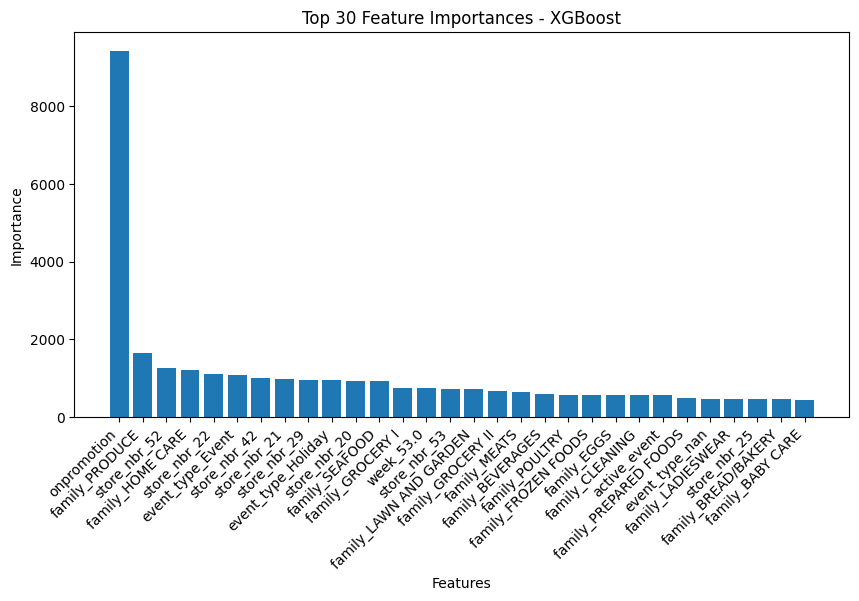

In [126]:
data_importance=model.get_score(importance_type="weight")

# Extract feature names and their corresponding importance scores
features = list(data_importance.keys())
importance = list(data_importance.values())

# Sort features based on importance
sorted_idx = np.argsort(importance)[::-1]

# Plot the top N features
top_n = 30  # Adjust the number as needed
plt.figure(figsize=(10, 5))
plt.bar(np.array(features)[sorted_idx][:top_n], np.array(importance)[sorted_idx][:top_n])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(f'Top {top_n} Feature Importances - XGBoost')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# #OLD VERSION
# optimized_models=dict()
# working_models=[0,1,2,5]
# working_models=[5]
# for i in working_models:
#     model_params=parameters[i]
#     algo=models[i]
#     print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++",end="\n")
#     print("MODEL CHOSEN:",algo.__name__,end="\n")
#     globals()[version+str(algo.__name__)]=model_fitter(X_train,y_train,algo,model_params,verbose=10,X_val=X_val,y_val=y_val)
#     optimized_models[version+str(algo.__name__)]=globals()[version+str(algo.__name__)]

# Now we can predict our sales

In [134]:
#columns to dummify
categorical_cols=["family","store_nbr","week","event_type"]
#columns to drop
drop_cols=["id","date","locale","description","city","store_type","cluster"]


X_test=data_cleaner(df_train,holidays,stores,categorical_cols,drop_cols,test_set=df_test)

Prepping the data...
Data prepped. Passing to the model section.



In [135]:
display(X_test.shape)
display(df_test.shape)

(28512, 146)

(28512, 5)

In [141]:
doos=xgboost.DMatrix(data=X_test,feature_names=X_test.columns)

In [140]:
help(xgboost.DMatrix)

Help on class DMatrix in module xgboost.core:

class DMatrix(builtins.object)
 |  DMatrix(data, label=None, missing=None, weight=None, silent=False, feature_names=None, feature_types=None, nthread=None)
 |  
 |  Data Matrix used in XGBoost.
 |  
 |  DMatrix is a internal data structure that used by XGBoost
 |  which is optimized for both memory efficiency and training speed.
 |  You can construct DMatrix from numpy.arrays
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __init__(self, data, label=None, missing=None, weight=None, silent=False, feature_names=None, feature_types=None, nthread=None)
 |      Parameters
 |      ----------
 |      data : string/numpy.array/scipy.sparse/pd.DataFrame/dt.Frame
 |          Data source of DMatrix.
 |          When data is string type, it represents the path libsvm format txt file,
 |          or binary file that xgboost can read from.
 |      label : list or numpy 1-D array, optional
 |          Label of the training data.
 |      mi

In [144]:
preds=model.predict(doos)
preds

array([1.7579167 , 0.14015815, 1.920974  , ..., 6.1278596 , 3.8554533 ,
       2.3053277 ], dtype=float32)

In [145]:
display(preds[preds<0])
print(preds[preds<0].sum(),preds[preds<0].mean())
print(preds[preds<0].shape)

array([-0.18555945, -0.2894004 , -0.17508554, ..., -0.34384567,
       -0.22602898, -0.18318641], dtype=float32)

-364.88306 -0.20373146
(1791,)


In [146]:
preds[preds<0]=0 #set negative to 0
preds=np.expm1(preds) #invert the log(1+x) prediction
preds

array([4.8003407e+00, 1.5045573e-01, 5.8276052e+00, ..., 4.5745383e+02,
       4.6250027e+01, 9.0274630e+00], dtype=float32)